Minimize 

Sum of dt

Subject to P = f(v) 

and the sum of v dt = Distance 

and Sum of P dt = E


In [100]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize
import pandas as pd

%load_ext nb_black

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [66]:
def power(v, θ):
    """Calculate power loss given ground speed velocity and angle

    Parameters
    ----------
    v : float
        Velocity (m/s)

    θ : float
        Angle (rad)

    Returns
    -------
    float
        Power loss (W)

    """
    c = 0.254
    M = 85
    g = 9.8

    return c * v**3 + M * g * v * np.sin(θ)

<IPython.core.display.Javascript object>

In [67]:
def power_to_speed(P, gradient):
    """Given a power P return the speed you'll get

    Parameters
    ----------
    P : float
        Power (W) to the pedals

    gradient : float
        Hill gradient (%)

    Returns
    -------
    float
        Part cost with breakdown of cost factors.

    """

    fun = lambda x: P - power(x, np.arctan(gradient / 100))
    sol = optimize.root(fun, 1)
    return sol.x[0]

<IPython.core.display.Javascript object>

In [73]:
KPH_PER_MPS = 3.6

power_to_speed(200, 5) * KPH_PER_MPS

15.540299173130276

<IPython.core.display.Javascript object>

Go over increments of 10 sec, integrate the velocity given a power. Integrate velocity and Power. 

In [91]:
gradients = {500: 2.1, 1000: 5.7, 1500: 3.9, 2000: 7.2, 99999: 10}
D = 4592  # meters
dt = 10  # secs
dist_traveled = 0
energy_spent = 0
total_time = 0


for i in range(999):
    P = 200
    for dist, g in gradients.items():
        if dist_traveled < dist:
            gradient = g
            break

    v = power_to_speed(P, g)
    dist_traveled += v * dt
    energy_spent += P * dt
    total_time += dt

    if dist_traveled > D:
        print("Done after", i)
        break

Done after 154


<IPython.core.display.Javascript object>

In [92]:
total_time / 60

25.833333333333332

<IPython.core.display.Javascript object>

In [93]:
dist_traveled

4615.168675894468

<IPython.core.display.Javascript object>

Add some 0 mean noise and see plot energy spent vs total time 

In [218]:
def random_power():
    return 200 + np.random.rand() * 20 - 10

<IPython.core.display.Javascript object>

In [219]:
def run():
    gradients = {500: 2.1, 1000: 5.7, 1500: 3.9, 2000: 7.2, 99999: 0}
    power_profile = {g: random_power() for d, g in gradients.items()}

    D = 4592  # meters
    dt = 10  # secs
    dist_traveled = 0
    energy_spent = 0
    total_time = 0
    power_profile_list = []
    for i in range(9999):
        #         P = 200 + np.random.rand() * 10 - 5
        for dist, g in gradients.items():
            if dist_traveled < dist:
                gradient = g
                break
        P = power_profile[gradient]
        power_profile_list.append(P)
        v = power_to_speed(P, g)
        dist_traveled += v * dt
        energy_spent += P * dt
        total_time += dt

        if dist_traveled > D:
            break
    return {
        "dist_traveled": dist_traveled,
        "total_time": total_time,
        "energy_spent": energy_spent,
        "power_profile": power_profile,
    }

<IPython.core.display.Javascript object>

In [220]:
data = [run() for i in range(1000)]

<IPython.core.display.Javascript object>

In [221]:
df = pd.DataFrame(data)
df

,dist_traveled,total_time,energy_spent,power_profile
0,4615.139457,730,147789.315264,"{2.1: 197.43504320753078, 5.7: 202.54032980721..."
1,4663.223653,750,146713.391619,"{2.1: 200.38547466508933, 5.7: 197.31474356378..."
2,4681.973144,740,147681.408412,"{2.1: 202.49866744071494, 5.7: 200.85533601735..."
3,4638.611304,740,145980.003535,"{2.1: 207.14040755782597, 5.7: 202.67662611502..."
4,4620.471301,730,148057.071675,"{2.1: 193.91163644112336, 5.7: 202.68572142282..."
...,...,...,...,...
995,4631.986083,740,148544.406908,"{2.1: 190.268918806257, 5.7: 203.1847054299293..."
996,4629.799360,730,148660.932212,"{2.1: 202.1608887694975, 5.7: 195.849193441337..."
997,4609.029945,730,147001.531579,"{2.1: 204.12253131703633, 5.7: 201.63021272209..."
998,4645.637984,730,149324.847056,"{2.1: 205.5086021576774, 5.7: 201.891065413718..."


<IPython.core.display.Javascript object>

In [222]:
df.describe()

,dist_traveled,total_time,energy_spent
count,1000.000000,1000.00000,1000.000000
mean,4636.971818,737.70000,147447.285432
std,27.131535,7.69215,1122.993634
min,4592.207799,720.00000,144242.219082
25%,4613.534967,730.00000,146586.277187
50%,4635.524696,740.00000,147385.822362
75%,4660.404444,740.00000,148173.634653
max,4684.375984,760.00000,150910.974072


<IPython.core.display.Javascript object>

<AxesSubplot:xlabel='energy_spent', ylabel='total_time'>

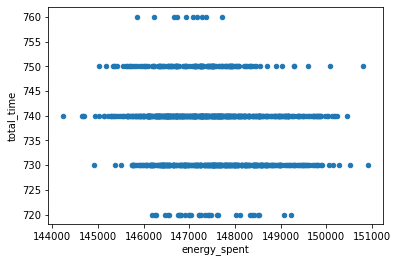

<IPython.core.display.Javascript object>

In [223]:
df.plot.scatter(x="energy_spent", y="total_time")

<AxesSubplot:>

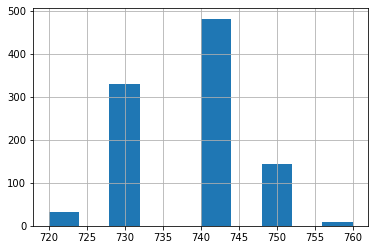

<IPython.core.display.Javascript object>

In [224]:
df.total_time.hist()

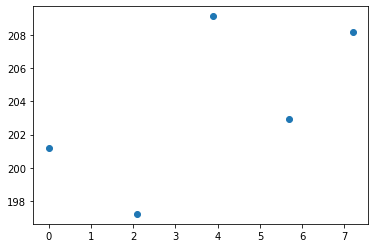

<IPython.core.display.Javascript object>

In [225]:
sel = df[df.energy_spent < df.energy_spent.mean()]

p = sel[sel.total_time == sel.total_time.min()].head(1).power_profile.values[0]

plt.scatter(p.keys(), p.values())

In [226]:
gradients = {500: 2.1, 1000: 5.7, 1500: 3.9, 2000: 7.2, 99999: 0}
gradients.values()

dict_values([2.1, 5.7, 3.9, 7.2, 0])

<IPython.core.display.Javascript object>